Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE" and remove every line containing the expression: "raise ..." (if you leave such a line your code will not run).

Do not remove any cell from the notebook you downloaded. If you need you can add any number of cells (and remove them if not more necessary). 

## IMPORTANT: make sure to rerun all the code from the beginning to obtain the results for the final version of your notebook, since this is the way we will do it before evaluating your notebook!!!

Fill in your name and id number (numero matricola) below:

In [85]:
NAME = "Gioel Adriano Vencato"
ID_number = int("2005829")

import IPython
assert IPython.version_info[0] >= 3, "Your version of IPython is too old, please update it."

---

# HOMEWORK #4
Unsupervised learning
In this notebook we are going to explore the use of unsupervised clustering methods.

In [86]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt

from scipy.stats import multivariate_normal
from sklearn.datasets import make_blobs

In [87]:
# TODO 1: Write a function to compute the pdf of a gaussian random vector, you just need to apply its definition.

def gv_normalizing_const(sigma : np.ndarray) -> np.float64:
    '''
    Function to compute the normalization coefficient of a vector valued Gaussian distribution.
    :param sigma: Covariance of the Gaussian random vector (d x d Positive Definite matrix). 
    '''
    # YOUR CODE HERE
    normalizing_const = 1/(np.sqrt(np.power(2*np.pi,sigma.shape[0]) * np.linalg.det(sigma)))
    return normalizing_const

def gaussian_pdf(x : np.ndarray, mu : np.ndarray, sigma : np.ndarray) -> np.ndarray:
    '''
    Function to compute the pdf of a vector valued gaussian distribution on the location x given its parameters: 
    mu and sigma. We are assuming sigma is invertible (you do not need to check its invertibility). For simplicity
    return the pdf with shape (1,1), this should be the shape you get after the quadratic form computation. 
    '''
    # YOUR CODE HERE
    unnomrmalized_pdf = np.exp(-0.5 * (x - mu).T @ np.linalg.inv(sigma) @ (x - mu))
    return gv_normalizing_const(sigma) * unnomrmalized_pdf

In [88]:
assert type(gv_normalizing_const(np.array([[2.]]))) == np.float64
# Test on scalar case
x = np.array([[1.]])
mean, cov = np.array([[2.5]]), np.array([[0.5]])
assert np.isclose(multivariate_normal.pdf(1, mean=mean, cov=cov), gaussian_pdf(x, mean, cov), atol=1e-3)

# Test on vector valued case
mean, temp = np.random.normal(2, 3, 2).reshape(-1,1), np.random.normal(2, 3, 4).reshape(2,2)
x = np.random.normal(2, 3, 2).reshape(-1,1)
cov = temp @ temp.T
hand_pdf = gaussian_pdf(x, mean, cov)
scipy_pdf = multivariate_normal.pdf(x.reshape(1,-1)[0], mean.reshape(1,-1)[0], cov)
assert np.isclose(hand_pdf, scipy_pdf, atol=1e-4)


Let's load a 1-D dataset which does not contain any label. It has been generated using K clusters. Can you tell 
how many clusters have been used by looking at the scatter plot?

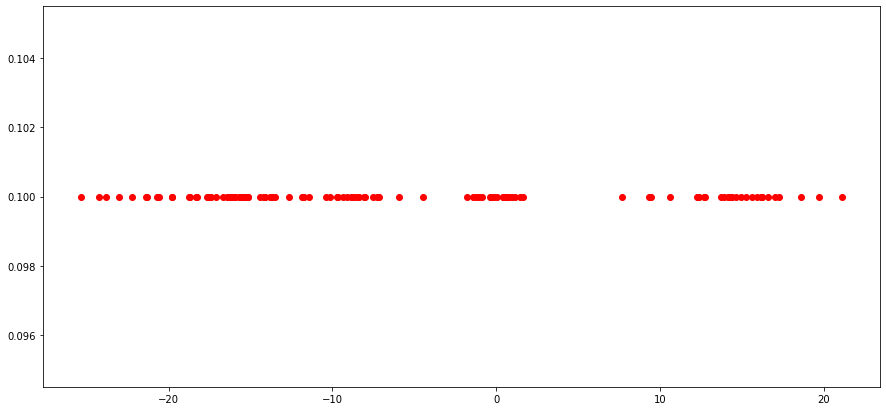

In [89]:
url = 'https://raw.githubusercontent.com/LucaZancato/ML2020-2021/main/HW_4/1_D_dataset.csv'
data = np.array(pd.read_csv(url, sep=';'))

plt.figure(figsize=(15,7))
for i, x in enumerate(data):
    plt.scatter(x, 0.1, color='r')

It's not trivial to judge how many clusters are present. Such an issue is present also in the case of EM on GMM (the one we are going to implement) and Kmeans: for both of these algorithms the number of clusters is fixed a priori, it is a parameter (hyper-parameter) we must decide before processing any datum.
Usually in order to achieve satisfactory clustering one needs to try with different number of classes and validate which is the best number. 

For now let's make it simple and let's consider the dataset has 3 clusters. 
In the following cell we shall parametrize 3 Gaussian random variables specifiying both means, covariances and mixing probabilities. Take a second to understand the way these parameters are stored, since the EM implementation is built on this notation. For now, means, cov and mixing probabilities are choosen without any specific criterion, we will see how EM applied to GMM will provide us a suboptimal set of means, covariances and mixing probabilities.

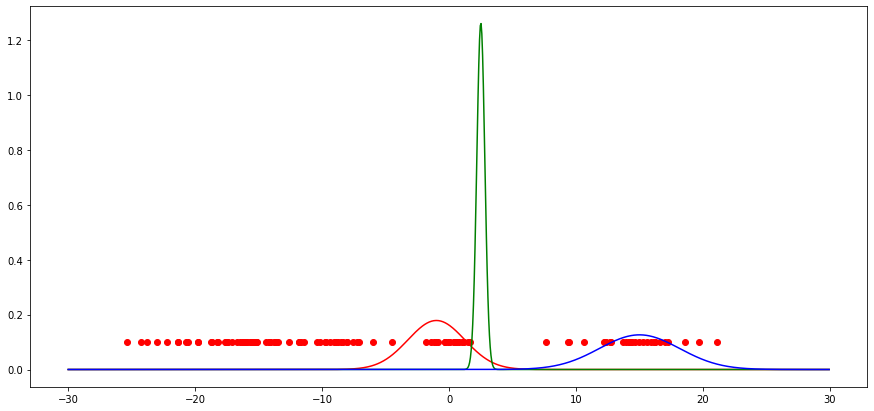

In [90]:
means = np.array([[-1],[2.5],[15]])      # KxF
covs  = np.array([[[5]],[[0.1]],[[10]]]) # KxFxF 
pi    = np.array([[1/2],[1/4],[1/4]])    # Kx1

X = np.linspace(-30, 30, 1000, endpoint=False).reshape(-1,1)
plt.figure(figsize=(15,7))
for i, x in enumerate(data):
    plt.scatter(x, 0.1, color='r')
plt.plot(X, [gaussian_pdf(x, means[0], covs[0]) for x in X], color='r')
plt.plot(X, [gaussian_pdf(x, means[1], covs[1]) for x in X], color='g')
plt.plot(X, [gaussian_pdf(x, means[2], covs[2]) for x in X], color='b')

In [91]:
# TODO 2: Write a function M_step which computes the M-step of the EM algorithm in case of a GMM. Refer 
# to the slides you can find on the moodle (in which ALL the necessary steps and expressions are present).
# Start by looking at the function "M_step" and then build all the help functions.

def update_pi(W : np.ndarray) -> np.ndarray:
    '''
    See M_step docs.
    '''
    # YOUR CODE HERE
    K = W.shape[1] # Number of clusters
    m = W.shape[0] # Number of data points
    new_pi = np.zeros(K) # new_pi.shape = (K,)
    for l in range(0,K):
      for i in range(0,m):
        new_pi[l] += W[i][l]
    new_pi = new_pi * 1/m
    return new_pi

def update_means(data : np.ndarray, W : np.ndarray) -> np.ndarray:
    '''
    See M_step docs.
    '''
    # YOUR CODE HERE
    K = W.shape[1] # Number of clusters
    m = data.shape[0] # Number of data points
    d = data.shape[1] # Dimension of each data point
    new_means = np.zeros(K*d).reshape(K,d) # new_means.shape = (K, d)
    new_means_num = new_means # new_means_num.shape = (K, d)
    new_means_den = np.zeros(K) # new_means_den.shape = (K,)
    for l in range(0,K):
      for i in range(0,m):
        new_means_num[l] += data[i] * W[i][l]
        new_means_den[l] += W[i][l]
      new_means[l] = new_means_num[l]/new_means_den[l]
    return new_means

def update_covs(data : np.ndarray, W : np.ndarray, new_means : np.ndarray) -> np.ndarray:
    '''
    See M_step docs.
    '''
    # YOUR CODE HERE
    K = W.shape[1] # Number of clusters
    m = data.shape[0] # Number of data points
    d = data.shape[1] # Dimension of each data point
    new_covs = np.zeros(K*d*d).reshape(K,d,d) # new_covs.shape = (K, d, d)
    new_covs_num = new_covs # new_covs_num.shape = (K, d, d)
    new_covs_den = np.zeros(K) # new_covs_den.shape = (K,)
    for l in range(0,K):
      for i in range(0,m):
        new_covs_num[l] += (data[i] - new_means[l]).reshape(-1,1) * (data[i] - new_means[l]).reshape(1,-1) * W[i][l]
        new_covs_den[l] += W[i][l]
      new_covs[l] = new_covs_num[l]/new_covs_den[l]
    return new_covs

def M_step(data : np.ndarray, W : np.ndarray) -> tuple:
    '''
    Function to compute the Maximization step on a GMM model (use the expressions derived on the slides).
    :param data: Dataset N x d (d := number of features)
    :param W: Weight matrix N x K (K :=number of classes). Element in position (i,j) represents the probability of
              i-th datum to belong to class j (j-th cluster) given the current parameters: pi, means, covs
    :returns: (new_pi, new_mu, new_cov)
        WHERE:
        new_pi: Contains the mixing probabilities. Its shape is (K,)
        new_mu: Contains the new means of the GMM model. Its shape is (K, d)
        new_cov: Contains the new covariances of the GMM model. Its shape is (K, d, d)
    '''
    new_pi    = update_pi(W)
    new_means = update_means(data, W)
    new_covs  = update_covs(data, W, new_means)
    
    return new_pi, new_means, new_covs 

In [92]:
W = np.array([[0.5, 0.5, 0],[0.5, 0, 0.5]])
assert np.isclose(update_pi(W), [0.5 , 0.25, 0.25], atol=1e-4).all()
W = np.random.normal(0,1, 1000).reshape(-1, 25) # Note this W is not normalized properly, we do not care not since we are testing only the output shape is correct
assert update_pi(W).shape == (25,)
# Test on the means update function
a = np.random.normal(0,1, 80).reshape(-1, 2)
b = update_means(a, W)
assert b.shape  == (25, 2)
# Test on the covs update function
assert update_covs(a, W, b).shape == (25, 2, 2)

In [93]:
# TODO 3: Write a function E_step which computes the E-step of the EM algorithm in case of a GMM. Refer 
# to the slides you can find on the moodle (in which ALL the necessary steps and expressions are present).
def E_step(data : np.ndarray, pi : np.ndarray, means : np.ndarray, covs : np.ndarray):
    '''
    Function to compute the Expectation step on a GMM model (use the expressions derived on the slides) given 
    the current values of the GMM parameters: pi, means, covs.
    :param data:  Same as M_step function.
    :param pi:    Same as M_step function.
    :param means: Same as M_step function.
    :param covs:  Same as M_step function.
    :returns: W, which is updated using the parameters of the GMM: pi, means, covs. W must be normalized (see 
              slides)
    '''
    # YOUR CODE HERE
    K = pi.shape[0] # Number of clusters
    m = data.shape[0] # Number of data points
    W = np.zeros(m*K).reshape(m,K) # W.shape = (m, k)
    W_num = W
    W_den = np.zeros(m) 
    for i in range(0,m):
      for l in range(0,K):
        W_num[i][l] = gaussian_pdf(data[i],means[l],covs[l]) * pi[l]
      W_den[i] = sum(W_num[i][:])
      W[i] = W_num[i][:] / W_den[i]
    return W

In [94]:
assert E_step(data, pi, means, covs).shape == (119, 3)
assert np.isclose(np.sum(E_step(data, pi, means, covs).sum(1) - 1), 0, atol=1e-4)

In [95]:
# TODO 4: Write a function to randomly initialize the parameters of a GMM. This is necessary to start with the 
# EM iterations. 

def randomly_initialize_W(data : np.ndarray, num_classes : int) -> np.ndarray:
    '''
    See random_init function docs.
    '''
    # YOUR CODE HERE
    m = data.shape[0] # Number of data points
    min = int(m/num_classes) # Min number of data per cluster 
    number_data_current_each_cluster = np.zeros(num_classes) # Current number of data that are assigned to each cluster
    clusters_not_filled = [i for i in range(0,num_classes)] # List of clusters which have not been filled
    W = np.zeros(m*num_classes).reshape(m,num_classes) # element in position (i,j) represents the probability of data-point 'i' to belongs to cluster 'j'
    i = 0 # i-th data point
    while (len(clusters_not_filled) > 0): # Each cluster has to contain 'min' data points
        k = np.random.choice(clusters_not_filled)
        W[i][k] = 1
        number_data_current_each_cluster[k] += 1
        if (number_data_current_each_cluster[k] == min):
          clusters_not_filled.remove(k)
        i += 1
    for j in range(i,m): # The remaining data-points go to the last filled cluster
      W[j][k] = 1
      number_data_current_each_cluster[k] += 1
    return W

def random_init(data : np.ndarray, num_classes : int) -> np.ndarray:
    '''
    Function to initialize W and GMM parameters. W is generated assigning randomly each datapoint only to one 
    cluster. We require to assign the same number of points for each cluster (even this is not striclty necessary
    to run the EM algorithm on GMM). If the number of data is not exactly divisible by the number of clusters 
    assign the exceeding data to one single class (it does not matter which one). 
    See M_step docs for details on W, interpretation and required shape.
    '''
    # Initialize W
    W = randomly_initialize_W(data, num_classes)
    # Use M_step to get GMM parameters
    pi, means, covs = M_step(data, W)
    return W, pi, means, covs

In [96]:
assert (randomly_initialize_W(np.random.normal(0,1, 100).reshape(-1,10), 5).sum(0) == 2).all()
assert (randomly_initialize_W(np.random.normal(0,1, 100).reshape(-1,5), 2).sum(0) == 10).all()
assert (randomly_initialize_W(np.random.normal(0,1, 100).reshape(-1,5), 3).sum(0) -6 == 2).any()

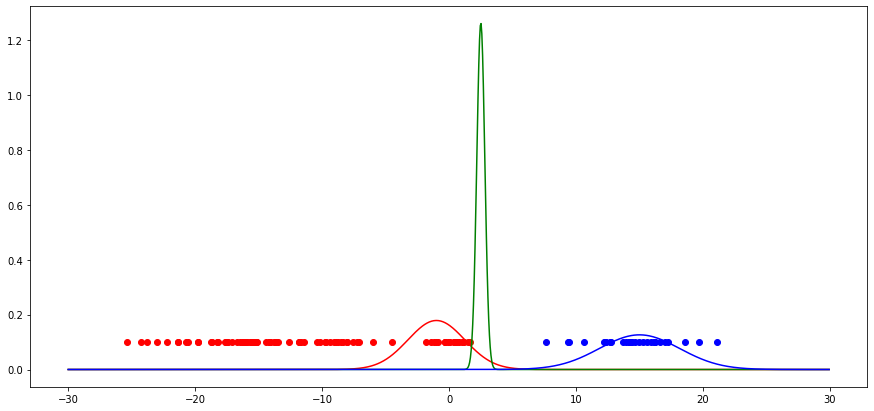

In [97]:
# Let's evaluate the class probability of each datum given current pi, means and covs. 
# Since we have 3 clusters we shall color code (rgb) each datum according to the class probabilities. Note that 
# it is not very likely to have a datum coming from the central (very peaked) distribution. 
W = E_step(data, pi, means, covs)

plt.figure(figsize=(15,7))
for i, x in enumerate(data):
    plt.scatter(x, 0.1, color=np.array([W[i][0], W[i][1], W[i][2]]))
plt.plot(X, [gaussian_pdf(x, means[0], covs[0]) for x in X], color='r')
plt.plot(X, [gaussian_pdf(x, means[1], covs[1]) for x in X], color='g')
plt.plot(X, [gaussian_pdf(x, means[2], covs[2]) for x in X], color='b')

In [98]:
# TODO 5: compute the log likelihood of an iid dataset under a GMM model.
def log_likelihood_GMM(data : np.ndarray, pi : np.ndarray, means : np.ndarray, covs : np.ndarray) -> float:
    '''
    Function to compute the log likelihood for a set of iid observations under a GMM. Use the function you built
    before "gaussian_pdf" to compute the likelihood. 
    :param data: N x d matrix containing a set of N iid data of dimension d
    :param pi:    Same as M_step function.
    :param means: Same as M_step function.
    :param covs:  Same as M_step function.
    '''
    # YOUR CODE HERE
    m = data.shape[0] # Number of data points
    K = pi.shape[0] # Number of clusters
    log_likelihood = 0
    for i in range(0,m):
      sum = 0
      for l in range(0,K):
        sum += gaussian_pdf(data[i],means[l],covs[l]) * float(pi[l])
      log = np.log(sum)
      log_likelihood += log
    return log_likelihood

In [99]:
assert type(log_likelihood_GMM(data, pi, means, covs)) == np.float64

Iteration 0, log likelihood -472.3874,  delta log likelihood 0.7805
Iteration 1, log likelihood -471.4456,  delta log likelihood 0.9418
Iteration 2, log likelihood -469.4984,  delta log likelihood 1.9472
Iteration 3, log likelihood -465.8965,  delta log likelihood 3.6019
Iteration 4, log likelihood -461.4710,  delta log likelihood 4.4255
Iteration 5, log likelihood -457.4700,  delta log likelihood 4.0010
Iteration 6, log likelihood -454.5480,  delta log likelihood 2.9219
Iteration 7, log likelihood -453.1872,  delta log likelihood 1.3608
Iteration 8, log likelihood -452.6860,  delta log likelihood 0.5012
Iteration 9, log likelihood -452.4526,  delta log likelihood 0.2334
Iteration 10, log likelihood -452.2991,  delta log likelihood 0.1535
Iteration 11, log likelihood -452.1754,  delta log likelihood 0.1237
Iteration 12, log likelihood -452.0679,  delta log likelihood 0.1074
Iteration 13, log likelihood -451.9727,  delta log likelihood 0.0952
Iteration 14, log likelihood -451.8880,  del

Text(0, 0.5, 'Log likelihood')

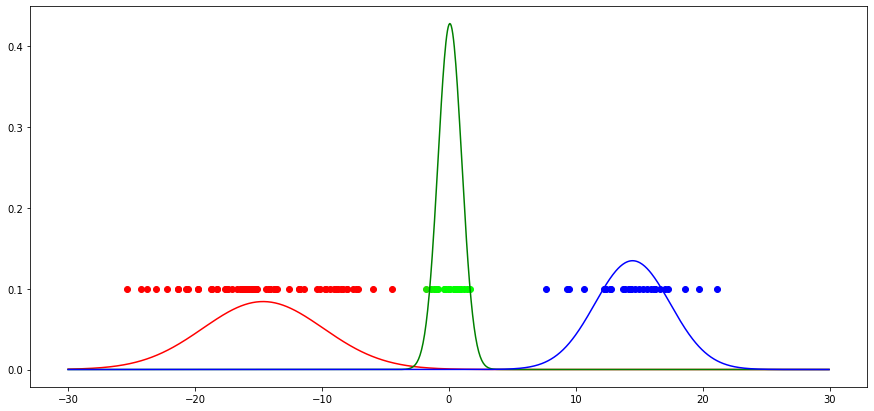

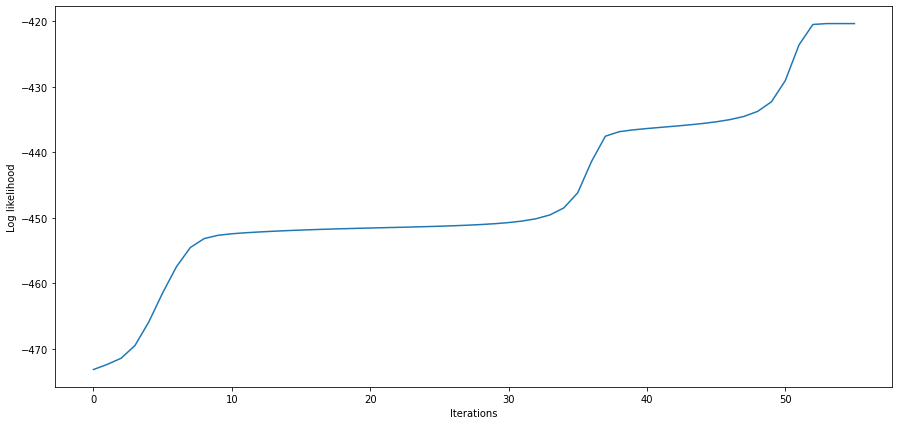

In [100]:
# TODO 6: Write a function to run the EM on GMM using the building blocks we created so far. Then test it on the 
# data we used so far (choose a meaningful max_iter, you do not need to exceed). 
def run_EM_on_GMM(data : np.ndarray, number_clusters : int, max_iter : int, epsilon : float = 1e-3,
                  plot_intermediate : bool = False) -> tuple:
    '''
    Function to run GMM on a given dataset and a given number of clusters. The termination conditions of the 
    iterative algorithm take into account either a specified max number of iterations or the improvement of the 
    log likelihood (if the log likelihood does not improve more than epsilon in two successive iterations we stop).
    :param data: N x d matrix containing a set of N iid data of dimension d
    :param number_clusters: # of clusters (information we have a priori, before starting the EM)
    :param max_iter: Maximum number of iterations allowed to the EM.
    :param epsilon: Threshold on the improvement of the log likelihood
    :param plot_intermediate: Boolean used to plot intermediate GMM for 2-d datasets (you do not need to implement
                              anything).
    :returns: (W, pi, means, covs, log_likelihood_train)
        WHERE:
        W:     Optimal W     after EM reaches termination condition (same shape as M_step function).
        pi:    Optimal pi    after EM reaches termination condition (same shape as M_step function).
        means: Optimal means after EM reaches termination condition (same shape as M_step function).
        covs:  Optimal covs  after EM reaches termination condition (same shape as M_step function).
        log_likelihood_train: log likelihoods obtained during training (saved using a list). 
    '''
    W, pi, means, covs = random_init(data, number_clusters)
    log_likelihood_train = [log_likelihood_GMM(data, pi, means, covs)]
    num_iter = 0
    # Used to plot 2-d data
    if plot_intermediate:
        x_max = np.max(np.abs(X))
        x, y = np.mgrid[-x_max:x_max:.05, -x_max:x_max:.05]
        pos = np.dstack((x, y))
    
    while (True): 
        # Iterate with E-Step and M-step
        # YOUR CODE HERE
        W = E_step(data,pi,means,covs) # E-step
        pi, means, covs = M_step(data,W) # M-step
        
        # Save log likelihood given current GMM parameters
        log_likelihood_train.append(log_likelihood_GMM(data, pi, means, covs)) 

        if plot_intermediate:
            # Plot scatter plot of training data and corresponding clusters    
            fig = plt.figure(figsize=(15,7))
            for k in range(0, number_clusters):
                plt.contour(x, y, multivariate_normal(means[k], covs[k]).pdf(pos))
            plt.scatter(data[0:,0], data[0:,1])
            plt.title(f'Iteration {num_iter}')

        print(f'Iteration {num_iter}, log likelihood {log_likelihood_train[-1]:.4f}, ' 
              f' delta log likelihood {(log_likelihood_train[-1] - log_likelihood_train[-2]):.4f}')
        num_iter += 1 
        
        # Use proper termination conditions, on: number of iteration or log likelihood improvement (use the 
        # break statement to stop while cycle)
        # YOUR CODE HERE
        if (num_iter == max_iter or (log_likelihood_train[-1] - log_likelihood_train[-2] < epsilon)):
          break
        
    return W, pi, means, covs, log_likelihood_train

# Let's try our implementation of the EM algorithm
max_iter = None
# YOUR CODE HERE
max_iter = 100
W, pi, means, covs, log_likelihood_train = run_EM_on_GMM(data, 3, max_iter, plot_intermediate=False)


plt.figure(figsize=(15,7))
for i, x in enumerate(data):
    plt.scatter(x, 0.1, color=np.array([W[i][0], W[i][1], W[i][2]]))
plt.plot(X, [gaussian_pdf(x, means[0], covs[0]) for x in X], color='r')
plt.plot(X, [gaussian_pdf(x, means[1], covs[1]) for x in X], color='g')
plt.plot(X, [gaussian_pdf(x, means[2], covs[2]) for x in X], color='b')

plt.figure(figsize=(15,7))
plt.plot(log_likelihood_train)
plt.xlabel('Iterations')
plt.ylabel('Log likelihood')

In [101]:
a, b, c, d, e = run_EM_on_GMM(data, 3, 10, plot_intermediate=False)
assert a.shape == (119, 3)
assert b.shape == (3,)
assert c.shape == (3, 1)
assert d.shape == (3, 1, 1)

Iteration 0, log likelihood -473.2557,  delta log likelihood 1.7949
Iteration 1, log likelihood -472.8305,  delta log likelihood 0.4251
Iteration 2, log likelihood -472.3612,  delta log likelihood 0.4694
Iteration 3, log likelihood -471.4392,  delta log likelihood 0.9220
Iteration 4, log likelihood -469.4965,  delta log likelihood 1.9428
Iteration 5, log likelihood -465.9093,  delta log likelihood 3.5872
Iteration 6, log likelihood -461.4982,  delta log likelihood 4.4111
Iteration 7, log likelihood -457.5311,  delta log likelihood 3.9672
Iteration 8, log likelihood -454.5937,  delta log likelihood 2.9374
Iteration 9, log likelihood -453.1918,  delta log likelihood 1.4019


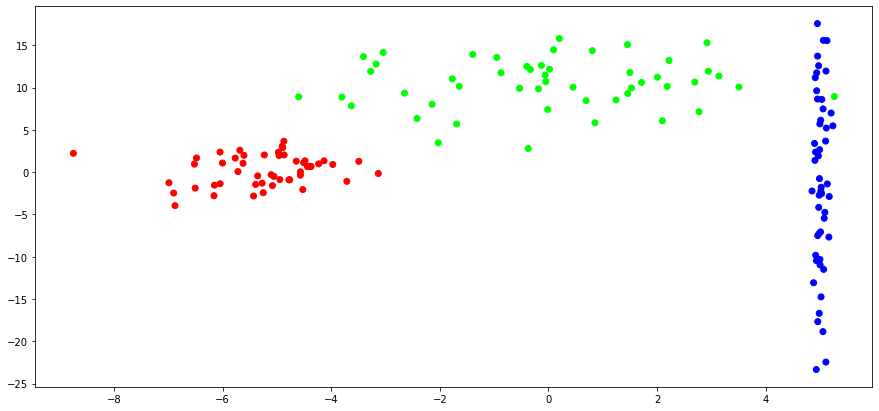

In [102]:
# We shall now use a 2-D dataset.
K = 3
clusters_cov = [[1,2], [2,3], [0.1,10]]
centers = [[-5, 0], [0, 10.5], [5, -1]]
X, Y = make_blobs(cluster_std=clusters_cov, centers=centers, random_state=ID_number, n_samples=150, shuffle=True)

colormap = np.array(['red', 'lime', 'blue'])

plt.figure(figsize=(15,7))
plt.scatter(X[:,0], X[:,1], c = colormap[Y])

Iteration 0, log likelihood -957.7108,  delta log likelihood 4.3414
Iteration 1, log likelihood -948.2295,  delta log likelihood 9.4813
Iteration 2, log likelihood -933.5157,  delta log likelihood 14.7138
Iteration 3, log likelihood -917.8476,  delta log likelihood 15.6681
Iteration 4, log likelihood -902.1687,  delta log likelihood 15.6789
Iteration 5, log likelihood -883.8192,  delta log likelihood 18.3495
Iteration 6, log likelihood -860.6582,  delta log likelihood 23.1610
Iteration 7, log likelihood -826.5395,  delta log likelihood 34.1188
Iteration 8, log likelihood -765.8856,  delta log likelihood 60.6539
Iteration 9, log likelihood -729.6724,  delta log likelihood 36.2131
Iteration 10, log likelihood -723.6266,  delta log likelihood 6.0459
Iteration 11, log likelihood -717.1956,  delta log likelihood 6.4309
Iteration 12, log likelihood -712.5896,  delta log likelihood 4.6060
Iteration 13, log likelihood -709.3025,  delta log likelihood 3.2871
Iteration 14, log likelihood -705.90

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Iteration 20, log likelihood -702.2918,  delta log likelihood 0.0008


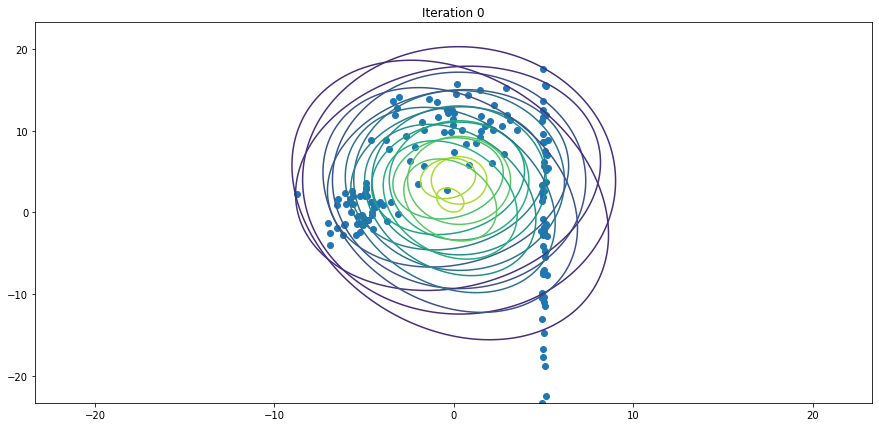

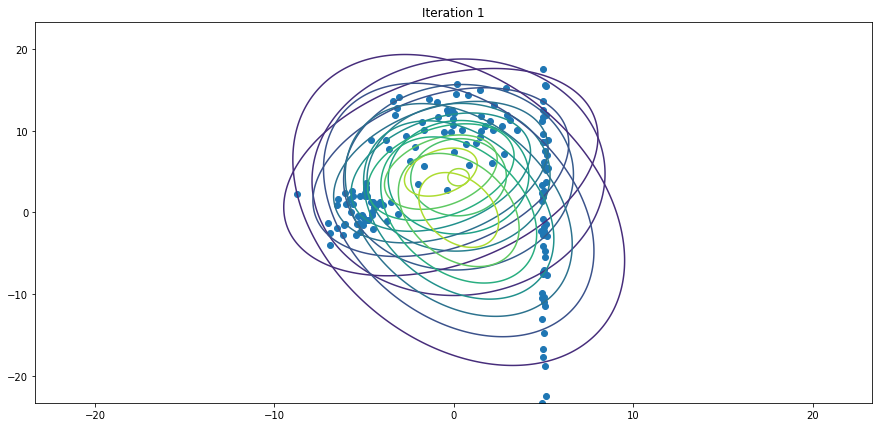

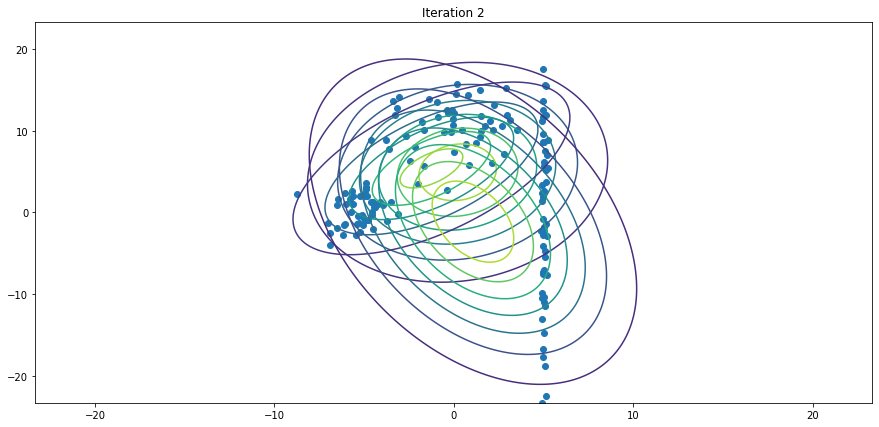

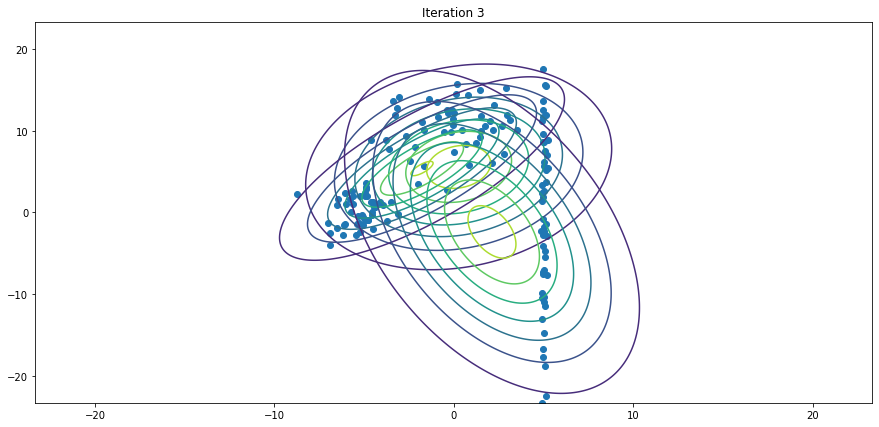

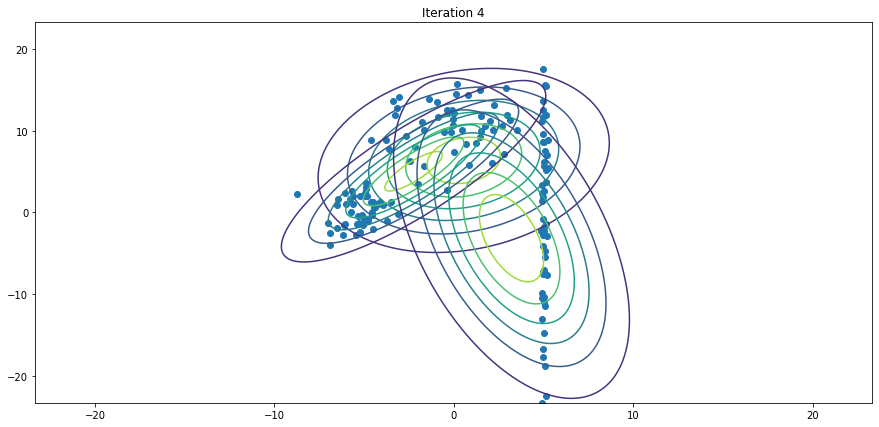

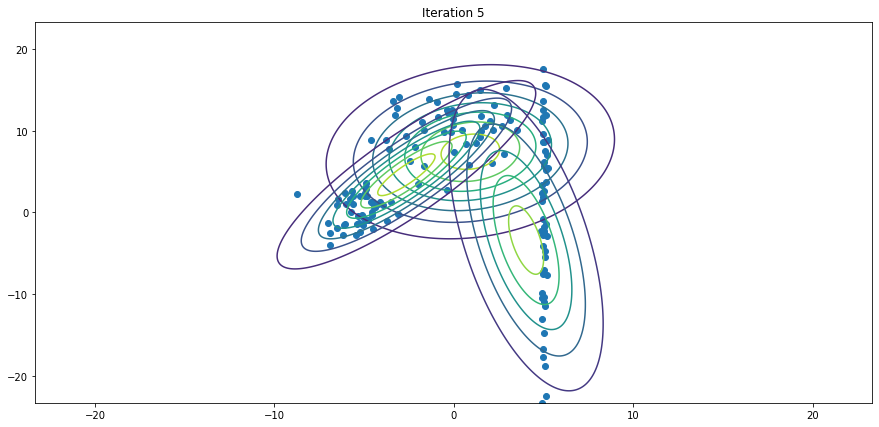

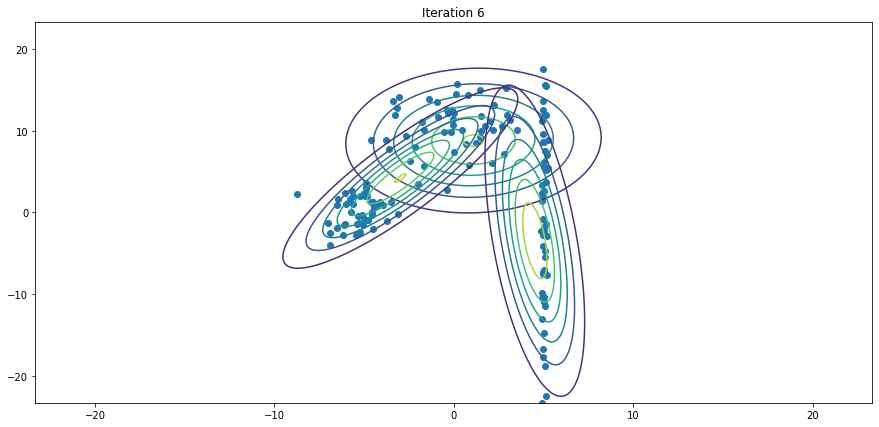

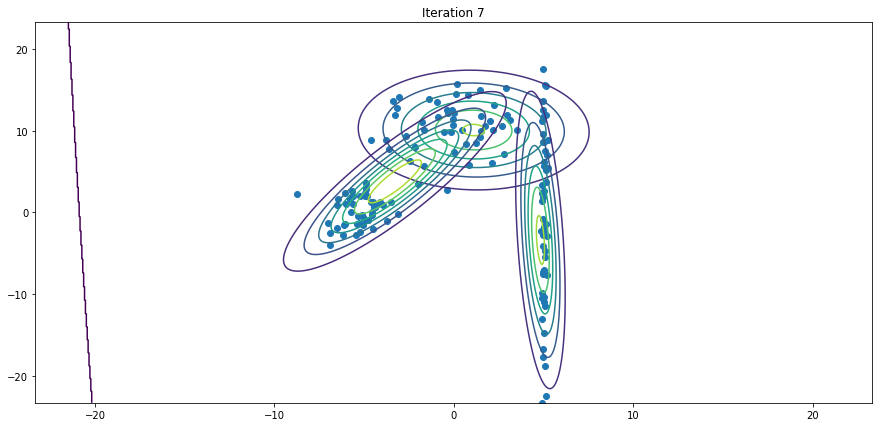

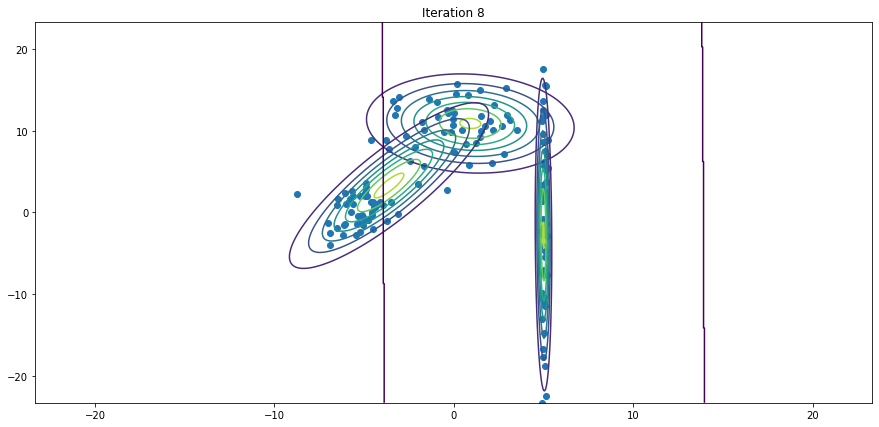

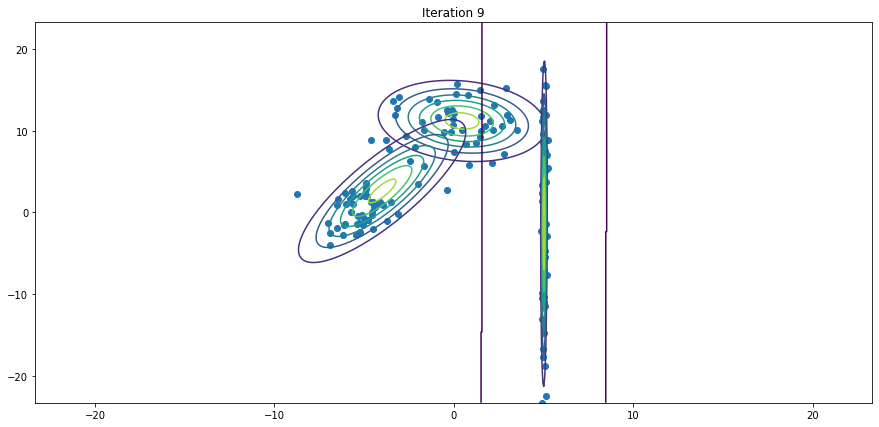

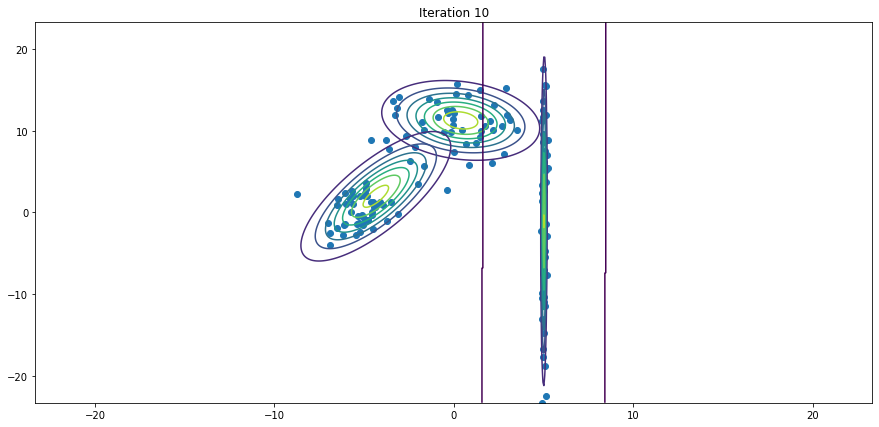

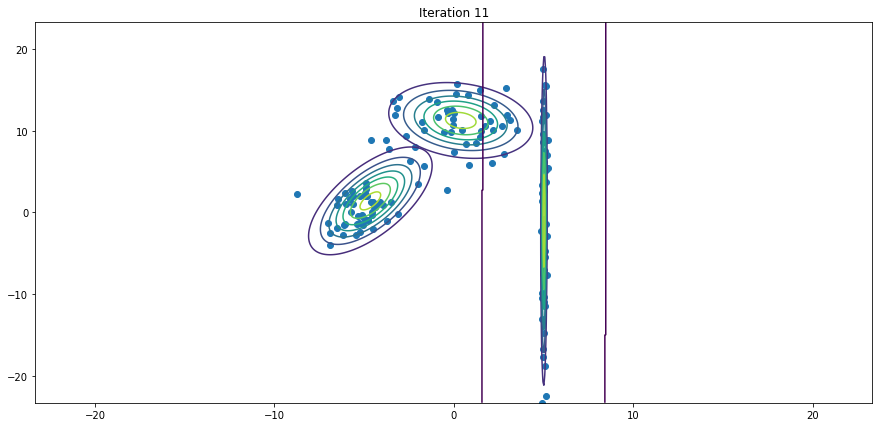

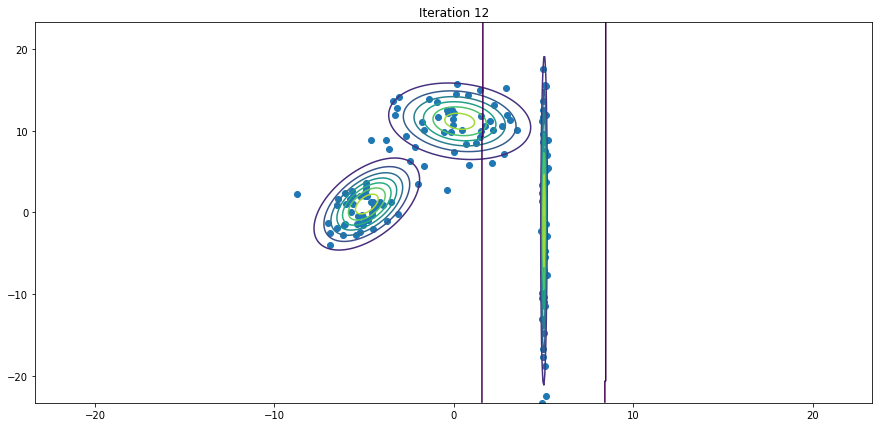

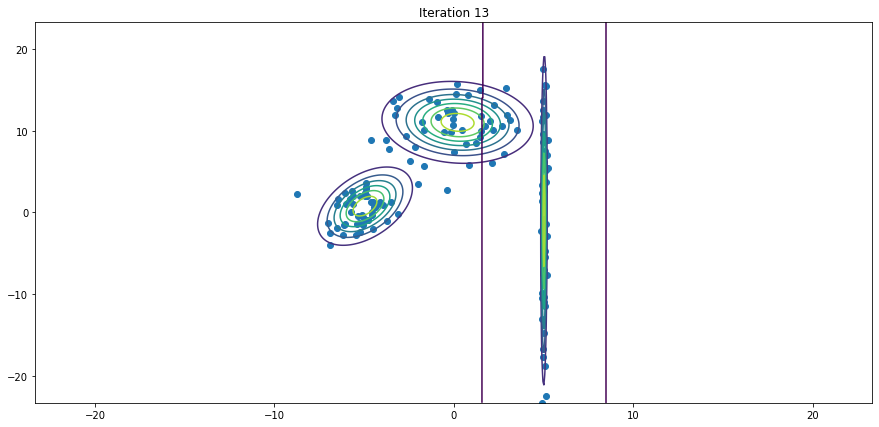

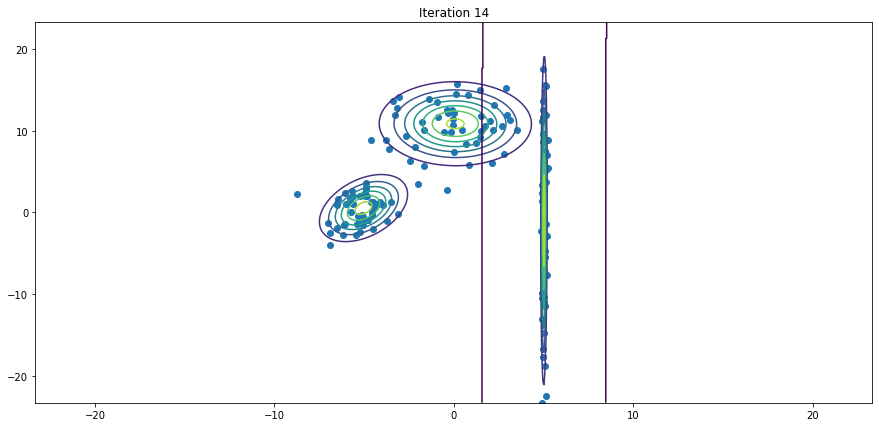

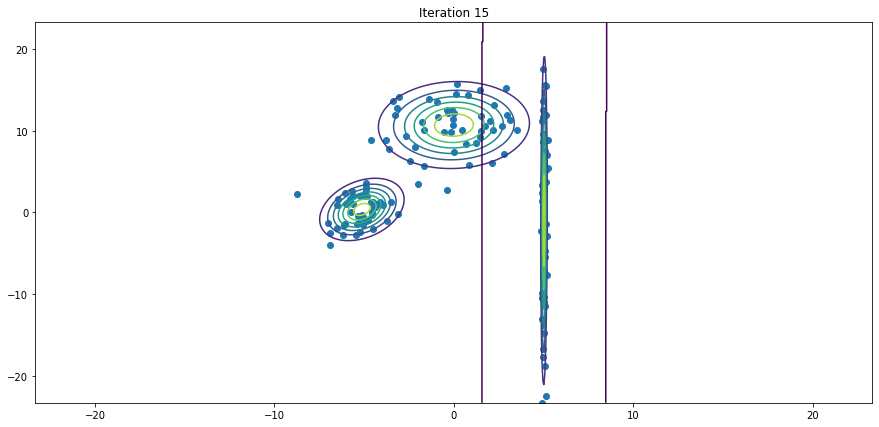

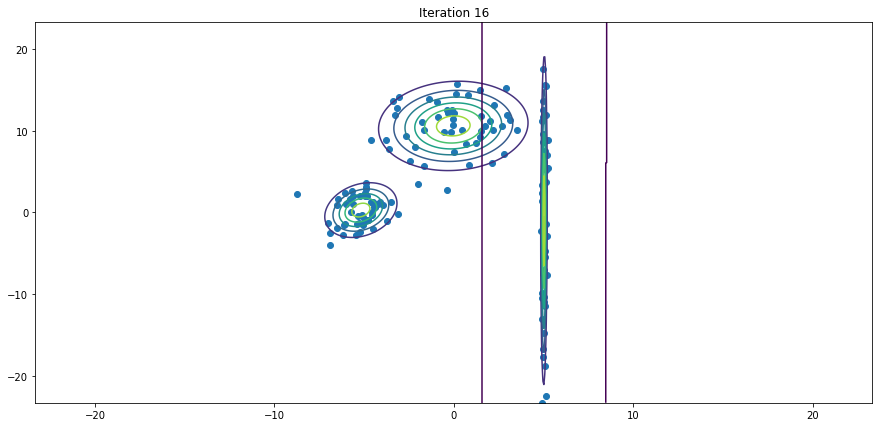

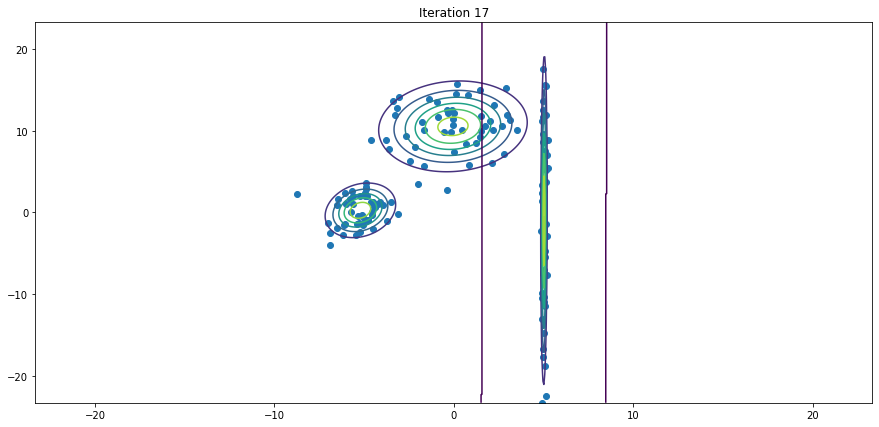

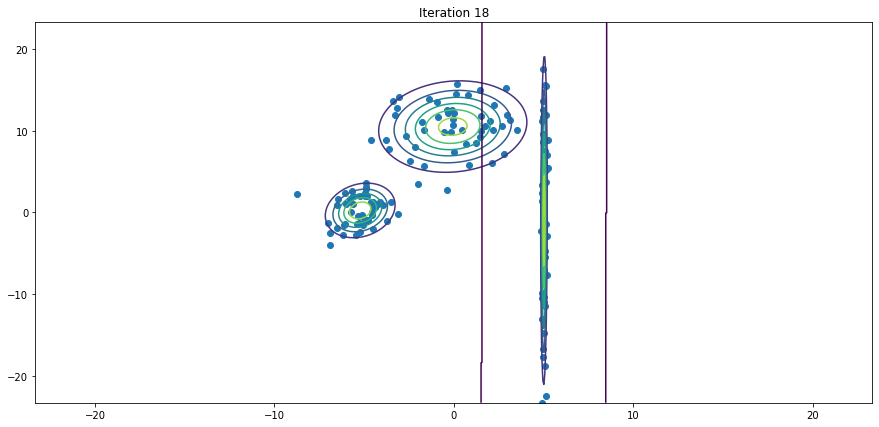

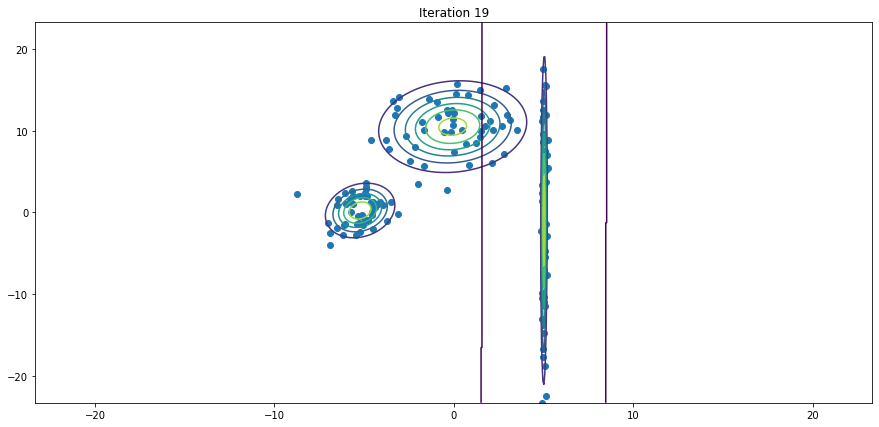

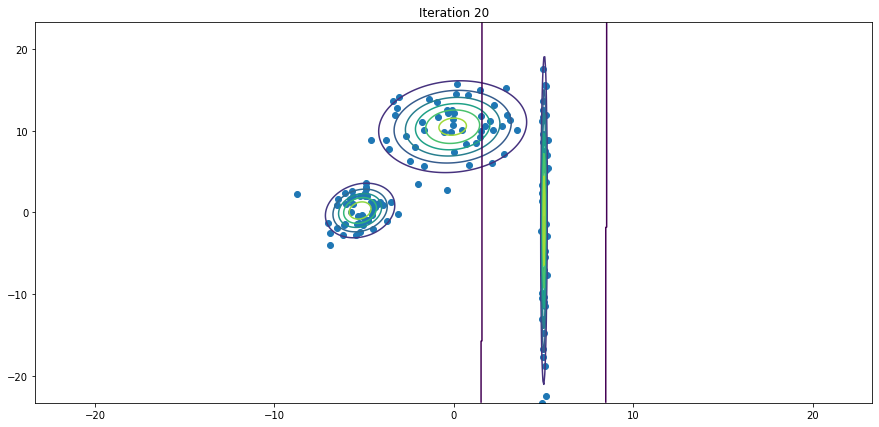

In [103]:
# Depending on your implementation this cell might take a while to run... (this is mainly due to the plots)
W, pi, means, covs, log_likelihood_train = run_EM_on_GMM(X, K, 150, plot_intermediate=True)

Text(0, 0.5, 'Log likelihood')

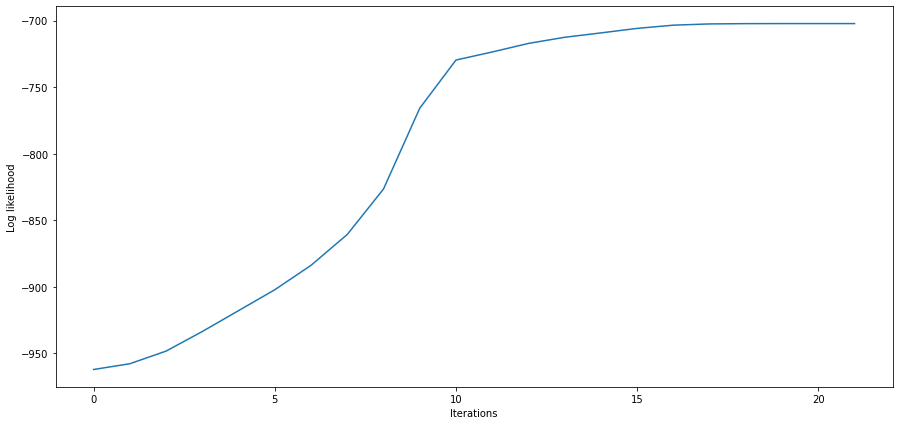

In [104]:
plt.figure(figsize=(15,7))
plt.plot(log_likelihood_train)
plt.xlabel('Iterations')
plt.ylabel('Log likelihood')

# TODO 7: explain the results you got (max 10 lines)

1-D dataset:
- Compare plots in to do 4 with the ones in to do 6, what has changed? Is EM providing us a meaningful clustering? 

2-D dataset:
- Why is the log likelihood monotonically increasing? Is this what you expect from the theory? Compare both log likelihood trajectory and 2-d plots.
- Is delta log likelihood monotonically going to zero?  
- Which termination criterion is met first?

(Answer in the next cell, no need to add code)

In [105]:
# YOUR CODE HERE
# ANSWER IN THE NEXT CELL

$\bf{ANSWER}$\
1-D DATASET\
In todo 4, given the initial parameter $\theta = \{\pi_j, \mu_j, \Sigma_j\}_{j = 1,2,3}$, after the computation of $W$ (using Bayes rule), to every data point has been attached the probability to belong to cluster j=1,2,3. In todo 6, the E-step and M-step have been computed at each iteration and hence the final parameters (the shape of the 3 gaussians) reflects more the distributions of the data, therefore EM is providing a meaningful clustering.


2-D DATASET\
At each iteration, the M-step of EM algorithm provides new values of the parameter $\theta$ to which it corrisponds a greater value of the log likelihood function  $(\log P_{\theta^{K+1}}(X_1,..,X_m) \geq \log P_{\theta^K}(X_1,..,X_m)$, where k is the number of iteration) and this is what i expect from theory. Moreover, as soon as the trajectory of the log likelihood function starts to increase less rapidly, the parameters of GMM stops changing significantly. As it is possible to note in the plot of the log-likelihood function, as the number of iterations increase the delta log-likelihood tends to be smaller, meaning that EM algorithm is converging to a local maxima of $\log P_{\theta}(X_1,..,X_m)$. In particular, when the delta log-likelihood is less than $\epsilon = 0.001$ ($\log P_{\theta^{K+1}}(X_1,..,X_m) - \log P_{\theta^{K}}(X_1,..,X_m) \leq \epsilon$) the algorithm stops and, in this case, it is the termination criterion that is met first.

In [106]:
# What is the effect of a wrong choice of the number of classes?
centers = [[-2, 0], [0, 3], [2, -1]]
X, Y = make_blobs(cluster_std=clusters_cov, centers=centers, random_state=20, n_samples=150, shuffle=True)

Ks = [2, 3, 4, 5, 6]
results = []
for k in Ks:
    results.append(run_EM_on_GMM(X, k, 150, plot_intermediate=False))

Iteration 0, log likelihood -797.8261,  delta log likelihood 2.7641
Iteration 1, log likelihood -790.4557,  delta log likelihood 7.3704
Iteration 2, log likelihood -777.6436,  delta log likelihood 12.8121
Iteration 3, log likelihood -766.0131,  delta log likelihood 11.6305
Iteration 4, log likelihood -754.2453,  delta log likelihood 11.7678
Iteration 5, log likelihood -741.5732,  delta log likelihood 12.6721
Iteration 6, log likelihood -732.2771,  delta log likelihood 9.2961
Iteration 7, log likelihood -725.5957,  delta log likelihood 6.6814
Iteration 8, log likelihood -713.3109,  delta log likelihood 12.2848
Iteration 9, log likelihood -694.6629,  delta log likelihood 18.6480
Iteration 10, log likelihood -679.8486,  delta log likelihood 14.8142
Iteration 11, log likelihood -675.2636,  delta log likelihood 4.5850
Iteration 12, log likelihood -674.3293,  delta log likelihood 0.9343
Iteration 13, log likelihood -674.1933,  delta log likelihood 0.1360
Iteration 14, log likelihood -674.179

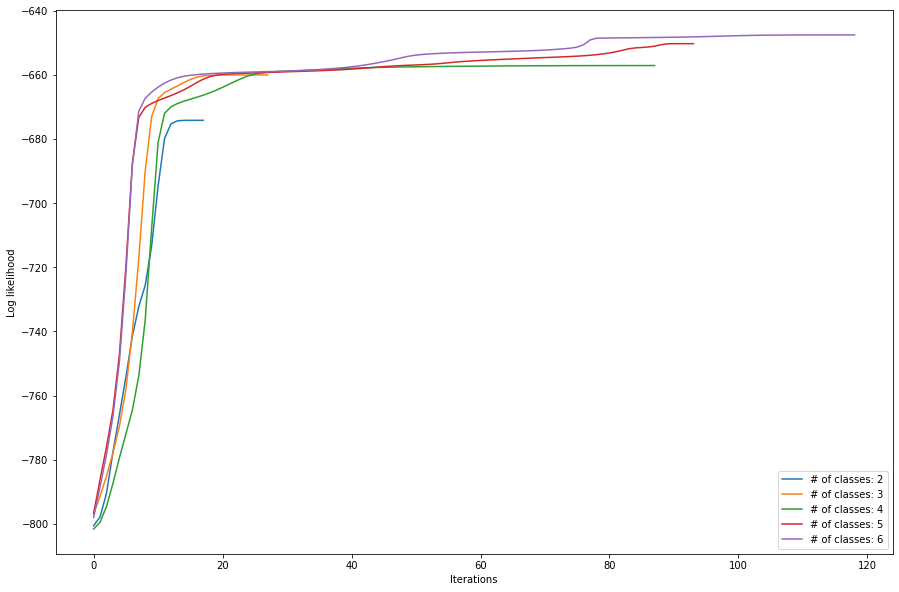

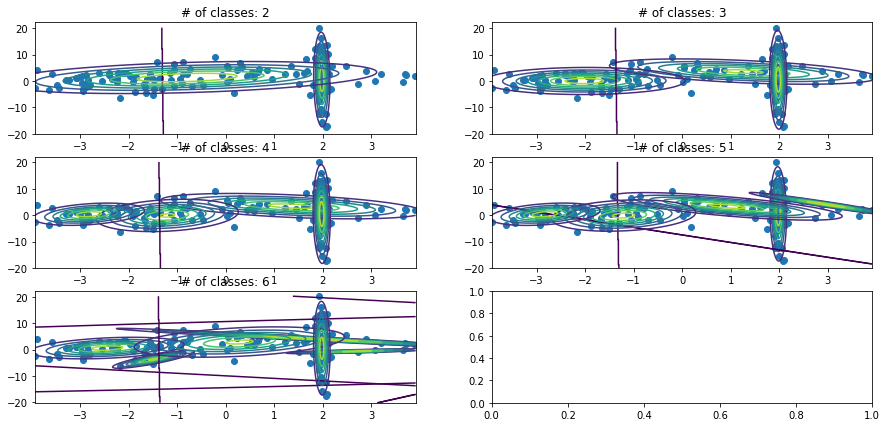

In [107]:
# Let's plot the log likelihood trajectories and the final 2-d Clustering
plt.figure(figsize=(15,10))
for res, k in zip(results, Ks): 
    plt.plot(np.array(res[-1]), label=f'# of classes: {k}')
plt.legend()
plt.xlabel('Iterations')
plt.ylabel('Log likelihood')

x_max, y_max = np.max(np.abs(X[:,0])), np.max(np.abs(X[:,1]))
x, y = np.mgrid[-x_max:x_max:.01, -y_max:y_max:.01]
pos = np.dstack((x, y))

fig, axes = plt.subplots(3, 2, figsize=(15,7))
# Plot scatter plot of training data and corresponding clusters    
for (_, pi, means, covs, _), K, ax in zip(results, Ks, axes.reshape(-1,)): 
    for k in range(K):
        ax.contour(x, y, multivariate_normal(means[k], covs[k]).pdf(pos), )
    ax.scatter(X[0:,0], X[0:,1])
    ax.set_title(f'# of classes: {K}')

# MNIST clustering

Let's apply GMM to a slightly more complex dataset: MNIST. In the following we shall use the sklearn implementation of the EM. Once we fit the GMM we shall visualize the centers in order to evaluate whether the clustering algorithm came up with a meaningful solution (in an ideal scenario we'd expect to have each center representing one single digit).

In [108]:
from sklearn.datasets import fetch_openml
from sklearn.mixture import GaussianMixture

X, Y = fetch_openml('mnist_784', version=1, return_X_y=True)
X = X / 255.

from sklearn.model_selection import train_test_split

m_t = 5000
x_train, x_test, y_train, y_test = train_test_split(X, Y, train_size=m_t/len(Y), random_state=ID_number, 
                                                    stratify=Y)

# Function to plot a digit and print the corresponding label
def plot_digit(vect_img, ax, cluster_id=None):
    ax.set_title(f'Cluster ID: {cluster_id}')
    ax.imshow(
        vect_img.reshape(28,28),
        cmap          = 'gray',
        interpolation = "nearest"
    )

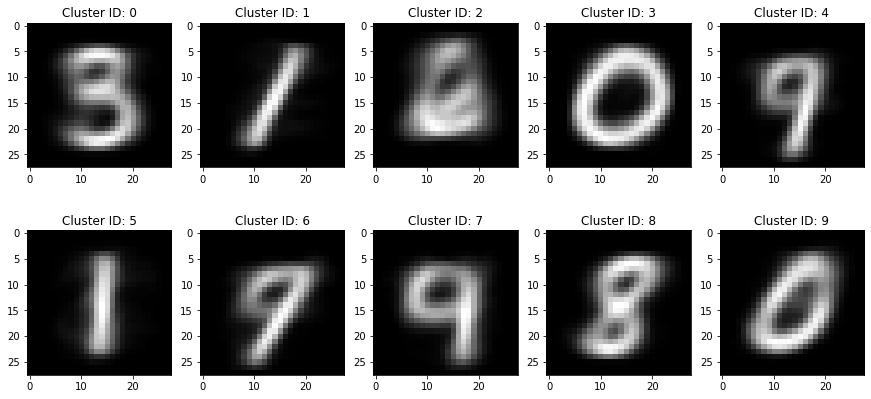

In [109]:
# TODO 8: use GaussianMixture from skelearn to cluster x_train and then predict the labels.
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

K = 10
# When you initialize the GaussianMixture object use set random_state=ID_number
gmm = None
gmm_pred = None
# YOUR CODE HERE
gmm = GaussianMixture(K,random_state=ID_number).fit(x_train)
gmm_pred = gmm.predict(x_train)

plt, axes = plt.subplots(2, K // 2, figsize=(15,7))
for k, ax in zip(range(K), axes.reshape(-1,)):
    plot_digit(gmm.means_[k], ax, cluster_id=k)   

In [110]:
assert gmm_pred.shape == (m_t,)

# Comparison with supervised models: 
In the next cell we shall compare Unsupervised methods (Kmeans and GMM) with a
Supervised method (NNs) on MNIST. 
Note that supervised methods cannot be applied in the unsupervised setting (i.e. we do not have any label). 
Nonetheless we can apply an unsupervised method to a supervised problem (we just need to neglect the extra piece 
of information we have: the labels). 
In the following we shall train both Kmeans and GMM as if we do not have labels and then we shall compare their
predictions to the ground truth labels. 

NOTE: in an unsupervised scenario we are not able to compare model predictions with ground truth labels since 
labels are not part of the problem statement.

In [111]:
# TODO 9: 
# Remember in ANY unsupervised clustering algorithm the name of the cluster DOES NOT possess any meaning. 
# The first class of the GMM model trained on the MNIST dataset does not necessarily represent the digits "0". 
# You can see this on the previous plots (plots of the centers of each component).
# Therefore we need to find a way to convert model clusters (predicitons) to ground truth labels. Several choices 
# are possible, in the following we shall use a very simple and straightforward rule: 
# 1- Find all the indeces of the data belonging to the same cluster predicted by the clustering model
# 2- Use these indeces (in the dataset) to gather the true labels
# 3- Compute the mode on the choosen true labels
# 4- Assign the mode as the new name of the cluster.
# In this way we are able to compare model predictions with the true labels (ground truth labels) and we can 
# compute the number of missclassified examples (as we did in previous Classification HWs). 

from scipy.stats import mode
def convert_prediction_labels(targets : np.ndarray, predictions : np.ndarray, num_clusters : int) -> np.ndarray:
    '''
    Function to assign a different label to the predictions of a clustering algorithm. Use the 4 steps described 
    earlier.
    :param targets: True labels (of shape (N,))
    :param predictions: Labels predicted by the clustering algorithm (of shape (N,))
    :param num_clusters: # of clusters in the training dataset
    :returns: 
        pred_labels: new labels for each datum (of shape (N,))
    '''
    pred_labels = np.zeros_like(targets)
    for k in range(num_clusters):
      # YOUR CODE HERE
      if (k == 0):
        pred_labels = -1 * np.ones_like(targets) # Pred_labels contains only '-1'
      from_predictions_to_indeces_k = [] # List which will contain the indeces {i} of the elements in the array 'predictions' for which 'predictions[i] = k'
      for i,val in enumerate(predictions): # if predictions[i] == k then i append index 'i' to the list 'from_predictions_to_indeces_k'
        if (val == k):
          from_predictions_to_indeces_k.append(i)
      from_indeces_to_true_labels_k = [] # List which will contain the true label of each element predicted as 'k'
      for i in from_predictions_to_indeces_k: # : from_indeces_to_true_labels_k[j] will contain the true label of the j-th element in 'from_predictions_to_indeces_k'
        from_indeces_to_true_labels_k.append(targets[i])
      most_common_digit = int(mode(from_indeces_to_true_labels_k)[0][0]) # Compute the mode on the chosen true labels
      for i in from_predictions_to_indeces_k: # Assign the mode as the new name of the cluster
        pred_labels[i] = most_common_digit
      pred_labels = pred_labels.astype('str')
    return pred_labels

def compute_score(targets, predictions, num_clusters):
    pred_labels = convert_prediction_labels(targets, predictions, num_clusters)
    errors = sum(pred_labels == targets)
    return (1 - errors / len(targets))

In [112]:
assert convert_prediction_labels(y_train, gmm_pred, 10).shape == (m_t,)

In [113]:
# TODO 10: Use sklearn GaussianMixture and KMeans to cluster x_train. Then evaluate the errors using the groud 
# truth labels (y_train) using the functions we built in the previous cell. Eventually we compare clustering 
# error rates with a supervised classification method: MLP.

# When you initialize the GaussianMixture and KMeans object use set random_state=ID_number
gmm, gmm_pred_train, gmm_pred_test = None, None, None
# YOUR CODE HERE
gmm = GaussianMixture(K,random_state=ID_number).fit(x_train)
gmm_pred_train = gmm.predict(x_train)
gmm_pred_test = gmm.predict(x_test)
gmm_tr_err   = compute_score(y_train, gmm_pred_train, K)
gmm_test_err = compute_score(y_test, gmm_pred_test, K)
print(f'GMM Training err    {gmm_tr_err:.4f}, Test err {gmm_test_err:.4f}')


from sklearn.cluster import KMeans
kmeans, kmeans_pred_train, kmeans_pred_test = None, None, None
# YOUR CODE HERE
kmeans = KMeans(K,random_state=ID_number).fit(x_train)
kmeans_pred_train = kmeans.predict(x_train)
kmeans_pred_test = kmeans.predict(x_test)
kmeans_tr_err   = compute_score(y_train, kmeans_pred_train, K)
kmeans_test_err = compute_score(y_test, kmeans_pred_test, K)
print(f'Kmeans Training err {kmeans_tr_err:.4f}, Test err {kmeans_test_err:.4f}')


from sklearn.neural_network import MLPClassifier
best_mlp_large = MLPClassifier(hidden_layer_sizes=(50, 50), max_iter=1000, alpha=1e-4, solver='sgd', tol=1e-4, 
                               random_state=ID_number, learning_rate_init=.1)
best_mlp_large.fit(x_train, y_train)
training_error = 1. - best_mlp_large.score(x_train, y_train)
test_error = 1. - best_mlp_large.score(x_test, y_test)

print(f'MLP Training err    {training_error:.4f}, Test err {test_error:.4f}')

GMM Training err    0.4780, Test err 0.5874
Kmeans Training err 0.4412, Test err 0.4379
MLP Training err    0.0000, Test err 0.0657


In [114]:
assert gmm_pred_train.shape == (m_t,)
assert gmm_pred_test.shape == (70000 - m_t,)
assert kmeans_pred_train.shape == (m_t,)
assert kmeans_pred_test.shape == (70000 - m_t,)

# TODO 11 (max 10 lines)
- What is the effect of a wrong choice of the number of clusters? Briefly describe both log likelihood as a function of iterations and optimal clustering (depicted on the 2-D plot). 
- The number of errors using GMM on MNIST is quite high, could have you predicted such a behaviour looking only at the center clusters visualized in to do 8? Why?
- Compare GMM, Kmeans and NN. Which is the best model? Why? Did you expect the result?


(Answer in the next cell, no need to add code)

In [115]:
# YOUR CODE HERE
# ANSWER BELOW

$\bf{ANSWER}$
-  The EM algorithm stops when the corresponding log-likelihood function does increase not more than $\epsilon$  and, for a wrong choice of the number of clusters, the final value of  $\log P_{\theta}(X_1,..,X_m)$ is inferior with respect to the one with a better choice of the number of clusters. As i have already mentioned, as the number of iterations increase also the log-likelihood increase and the optimal value of K is the one for which the EM algorithm has converged to a greater value of log-likelihood.
- As i move in $\mathbb{R}^d$ (d = 784), i expect the digits which are closer to the center of the specific cluster to be similar to it and hence that they represent the same digit. Therefore, by looking at the center clusters i expect that approximately $\frac{4}{10}$ of the training data are assigned to the wrong cluster by GMM which is compatible with the large training error.
- I observe that after that model predictions have been converted to ground true labels, there are few true labels that have not been assigned to any datapoint and it is the reason why GMM and Kmeans have high training and test error. On the other hand, NN achieves zero training error and small test error and therefore, because of the fact that to all digits are assigned the correct labels, it represents a better choice w.r.t. GMM and Kmeans.